<a href="https://colab.research.google.com/github/divyanshgupt/travelling-wave-mec/blob/main/Raster_Plot_Theta_Cycle_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from matplotlib import animation

Assumptions:
1. Each module contains the same number of cells
2. Self similarity (the grid fields become smaller
3. All cells within the same module have the same spatial period (the definition of a module)
 

### 1-D Von Mises Function (for Encoding)

$$ \Omega_j = n_{max} e^{\kappa(cos(\omega (x - c_j)) - 1)}$$ 

In [ ]:
def von_mises(position, lam, phase, args):
  """
  Maps animal position to grid cell receptive field intensity to model the hexagonal lattice
  inputs:
    position - x-coordinate
    lam - the spatial period of the grid cell
    phase - the preferred relative phase of the grid cell
    args: ['K', 'n_max']
  returns:
    von-mises valuea the given position coordinate
  """
  K = args['K']
  n_max = args['n_max']

  w = 2*np.pi / lam

  value = n_max * np.exp(K*(np.cos(w*(position - phase)) - 1))

  return value

In [ ]:
def poisson_cells(rate, args):
  """
  Returns a spike or no spike in the given time-bin for cells with given parameters
  inputs:
    rate - average rate of firing, shape: (nb_cells)
    args['step_size']
  returns:

  """
  nb_cells = args['nb_cells']
  dt = args['step_size']
  
  random = np.random.uniform(size=(nb_cells))
  activity = np.zeros(nb_cells)
  determinant = random - (rate*dt) # shape: nb_cells
  activity[determinant <= 0] = 1

  return activity 

In [ ]:
def grid_module(lam, args):
  """
  Distributes position relative phase among cells in a linear orderly fashion for a single grid cell module
  inputs:
    args:['nb_cells']
  returns:
    array of x-coordinates denoting relative phasese of subsquent cells
  """
  
  nb_cells = args['nb_cells']
  step = lam/nb_cells
  phases = np.arange(0, lam, lam/nb_cells)

  return phases

In [ ]:
def multiple_modules(args):
  """
  Generates phases for multiple modules based on given parameters
  inputs:
    args - ['nb_modules', 'lam_0', 's']
  returns:
    phases - list of numpy arrays containing phases for individual modules
  """

  nb_modules = args['nb_modules']
  lam_0 = args['lam_0']
  s = args['s']

  phases = []

  for i in range(nb_modules):
    lam = lam_0/(s**(nb_modules-i-1))
    phases.append(grid_module(lam, args))

  return phases

### Positon Theta Phase Model
(Adapted from McClain et al., 2019)
**Spatial Input Equation**: (Gaussian to model place cell field)
$$ f = e^{A_x}e^{\frac{-(x-x_0)^2}{2\sigma^2_x}}  $$

**Phase modulation equation**:
$$ g(\theta,x) = e^{k_\theta(cos(\theta - \theta_0(x)) - 1)} $$

**Phase precession equation**:
$$ \theta_0(x) = b_\theta + m_\theta(x - x_0) $$

$ b_\theta = 0 $: preferred phase at the center of the place field

$ m_\theta = 1 $: rate of phase precession

**Rate** (modelled as a product of the spatial input and phase modulation equations):
$$ r(x, \theta) = f(x)\bullet g(\theta, x) $$

_______________________

**Spatial Input Equation** (von Mises tuning for grid fields):
$$ \Omega_j(\vec{x}) =  n_{max}e^{\frac{\kappa}{3} \Sigma_{l=1}^3(cos(\omega \vec{k_l}\bullet (\vec{x} - \vec{c_j})) - 1)}$$

**Phase modultion equation**:    
$$ g(\theta, \vec{x}) = e^{k_\theta(cos(\theta - \theta_0(\vec{x}))-1)} $$

**Phase precession (2-D)**:
$$ \theta_0(\vec{x}) = b_\theta + m_\theta(|\vec{x} - \vec{x_0}|)  $$


**Rate**:
$$ r(\vec{x}, \theta) = f(x)\bullet g(\theta, \vec{x})$$


------------------------------------



In [ ]:
def phase_precession(position, args):
  """
  Models phase precssion as a linear function of position, based on McClain et al., 2019
  inputs:
    position - x-coordinate (in absolute frame)
    ref - origin x-coordinate
    args: ['b_theta', 'm_theta', 'x_0']
  returns:
    value of theta_0 (scalar)
  """
  b_theta = args['b_theta']
  m_theta = args['m_theta']
  ref = args['x_0']

  theta_0 = b_theta + m_theta*(position - ref)

  return theta_0

In [ ]:
def phase_modulation(theta, theta_0, position, args):
  """
  
  inputs:
    theta - 
    theta_0 - 
    position - 
    args:['k_theta']
  returns:
    phase modulation factor value at given postion
  """
  k_theta = args['k_theta']
  theta_0 = phase_precession(position, args)
  modulation_factor = np.exp(k_theta * (np.cos(theta - theta_0)))

  return modulation_factor

In [ ]:
def theta_phase(args):
  """
  Initializes theta phase for all cells in a linear fashion
  inputs:
    args - ['theta_offset', 'nb_cells', 'nb_modules']
  returns:
    theta phase value across all cells
  """
  offset = (np.pi/180)*args['theta_offset']
  nb_cells = args['nb_cells']
  nb_modules = args['nb_modules']

  offset_step = offset/(nb_cells*nb_modules)
  theta = np.arange(0, offset, offset_step)

  return theta

### Plotting

In [ ]:
def raster_plot_module(activity, title, args, figsize=[25,5], dpi=150):
  """
  plots a raster plot for cells in a module
  inputs:
    activity: spike trains within a module, shape: (nb_cells, nb_steps)
  returns:

  """
  nb_steps = args['nb_steps']
  dt = args['step_size']

  plt.figure(figsize=figsize, dpi=dpi)
  for i, row in enumerate(activity):
    positions = np.arange(0, nb_steps)
    spike_positions = dt*positions[row >= 1] # those spike positions steps where the the neuron fires
    plt.eventplot(spike_positions, lineoffsets=i)

  plt.title(title)
  plt.xlabel("Time (in secs)")
  plt.ylabel("Cell Id")
  plt.show()

def raster_plot_singlecell(spike_train, title, args, figsize=[25, 5], dpi=150):
  """

  inputs:
    spike_train: array of zeros and ones
    title: title for the plot (string)
    args: ['nb_steps', 'step_size']
  returns:
    
  """

  nb_steps = args['nb_steps']
  dt = args['step_size']

  
  positions = np.arange(0, nb_steps)
  spike_positions = dt*positions[spike_train >= 1] 

  plt.figure(figsize=figsize, dpi=dpi)
  plt.eventplot(spike_positions)
  plt.title(title)
  plt.xlabel("Time (in secs)")
  plt.show()


In [ ]:
def plot_modulation_factor(modulation_factor, title, args, figsize=[25, 5], dpi=150):
  """
  inputs:
    modulation_factor - theta modulation or spatial input in the McClain model - shape:(nb_steps)
    args - ['step_size', 'nb_steps']
  returns:
    
  """
  dt = args['step_size']
  nb_steps = args['nb_steps']

  plt.figure(figsize=figsize, dpi=dpi)
  time = np.arange(0, nb_steps*dt, dt) # x-coordinates in plot

  plt.plot(time, modulation_factor)
  plt.title(title)
  plt.xlabel("Time (in secs)")
  plt.show()

### Simulation

In [ ]:
def simulate(args):
  """
  Runs the whole simulation and returns grid cell activity over time as the animal moves in space

  inputs:

  returns:
    
  """

  nb_steps = args['nb_steps']
  dt = args['step_size']
  v = args['animal_velocity'] # assuming constant velocity over the duration
  nb_cells = args['nb_cells']
  nb_modules = args['nb_modules']
  freq = args['theta_freq']
  lam_0 = args['lam_0'] # spatial period of the largest module
  s = args['s']
  omega = 2*np.pi*freq
  
  animal_position = 0 # starts at origin

  module_spatial_phases = multiple_modules(args) # initializes the preferred phases 
  theta_phases = theta_phase(args) # initializes the theta phases linearly for all cells

  activity = np.zeros((nb_cells, nb_steps, nb_modules))
  
  modulation_factor = np.zeros((nb_cells, nb_steps, nb_modules))
  spatial_input = np.zeros((nb_cells, nb_steps, nb_modules))

  for t in tqdm(range(nb_steps)):

    animal_position += dt*v
    
    theta_phases += omega*dt

    for i in range(nb_modules): # simulate for modules going from dorsal to ventral
      
      lam = lam_0 / (s**(nb_modules-i+1))  
      
      theta = theta_phases[i*nb_cells:(i+1)*nb_cells] # shape: (nb_cells)
      #print(theta.shape) 
      theta_0 = phase_precession(animal_position, args) # scalar

      modulation_factor[:, t, i] = phase_modulation(theta, theta_0, animal_position, args) # modulation factors for all cells in the module, shape: (nb_cells)
     # modulation_factor_rec[:, t, i] = modulation_factors

      #print("Modulation factors shape:", modulation_factors.shape)
      spatial_input[:, t, i] = von_mises(animal_position, lam, module_spatial_phases[i], args) # shape:(nb_cells)
      #print("Spatial_input shape:", spatial_input.shape)
     # rates = phase_modulation(theta, theta_0, animal_position, args) * von_mises(animal_position, lam, module_spatial_phases[i], args) #shape: (nb_cells,)
      rates = modulation_factor[:, t, i] * spatial_input[:, t, i]
      #print(rates.shape)
      activity[:, t, i] = poisson_cells(rates, args)

  return activity, modulation_factor, spatial_input

In [ ]:
#@title Model Parameters
args = {'lam_0': 10, # spatial period of the largest module
        'K': 50,
        'n_max': 20,
        'nb_cells': 100, #no. of cells per module
        'nb_modules': 4,
        's': 1.5, # scaling ratio
        'b_theta': 0,
        'm_theta': 2*np.pi/10,   # rate of theta phase precession
        'k_theta': 1,
        'x_0': 0, # origin for phase precession
        'animal_velocity': 1, # m/sec
        'step_size': 0.01, # sec 
        'nb_steps': 100,
        'theta_offset': 40, # degrees # total theta phase offset from the dorsal to the ventral end, defining the travelling wave
        'theta_freq': 8 , # Hz # Frequency of theta oscillations
        }

In [ ]:
activity, theta_modulation, spatial_input = simulate(args)

100%|██████████| 100/100 [00:00<00:00, 3311.36it/s]


In [ ]:
print(activity.shape) #should be (nb_cells, nb_steps, nb_modules)

(100, 1000, 4)


In [ ]:
print(activity[0 ,:, 0]) # to look under the hood at a spike train

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

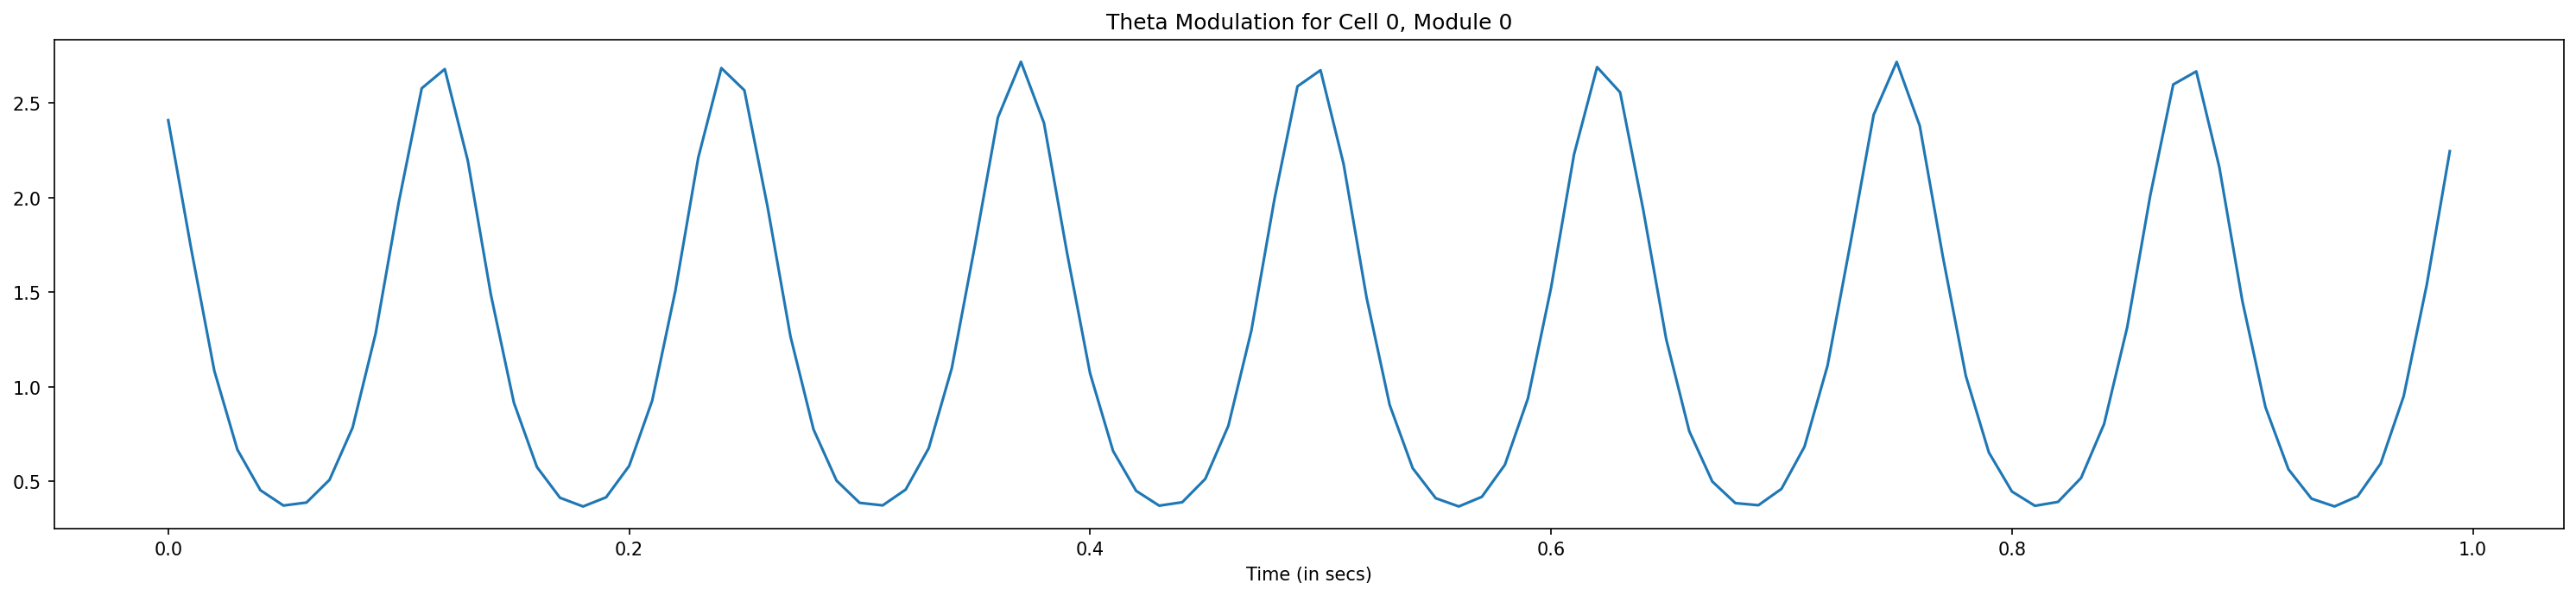

In [ ]:
# Plot the Theta Modultion for Cell 0 in Module 0
plot_modulation_factor(theta_modulation[0, :, 0], "Theta Modulation for Cell 0, Module 0", args)

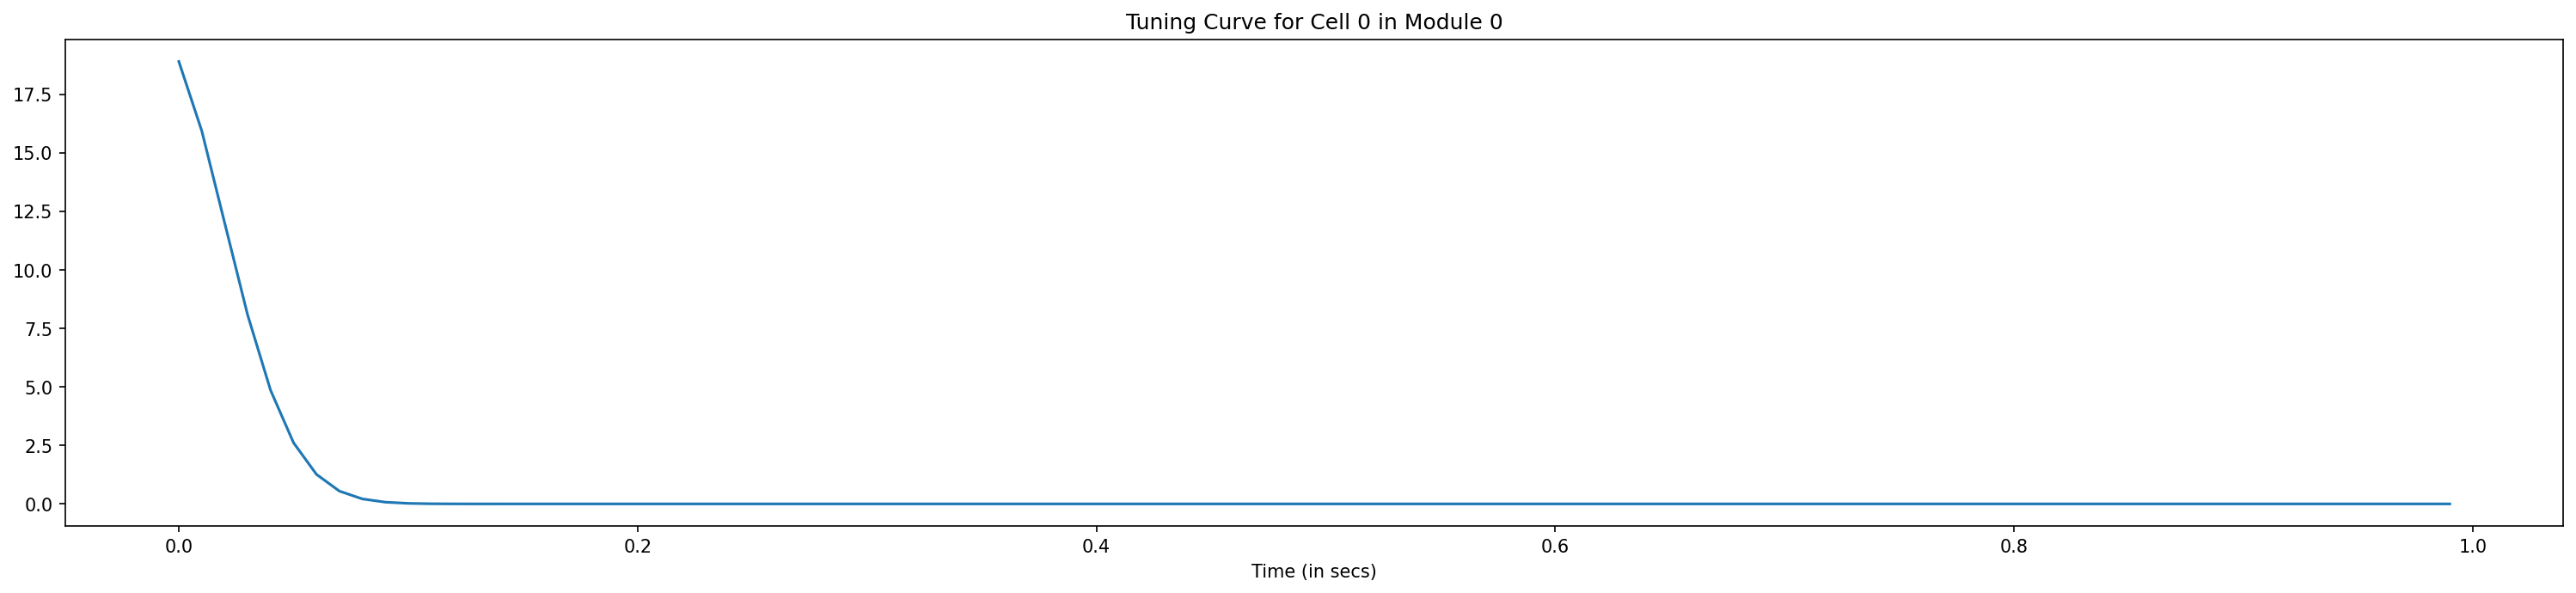

In [ ]:
# Plot the Tuning Curve of Cell 0 in Module 0
plot_modulation_factor(spatial_input[0, :, 0], "Tuning Curve for Cell 0 in Module 0", args)

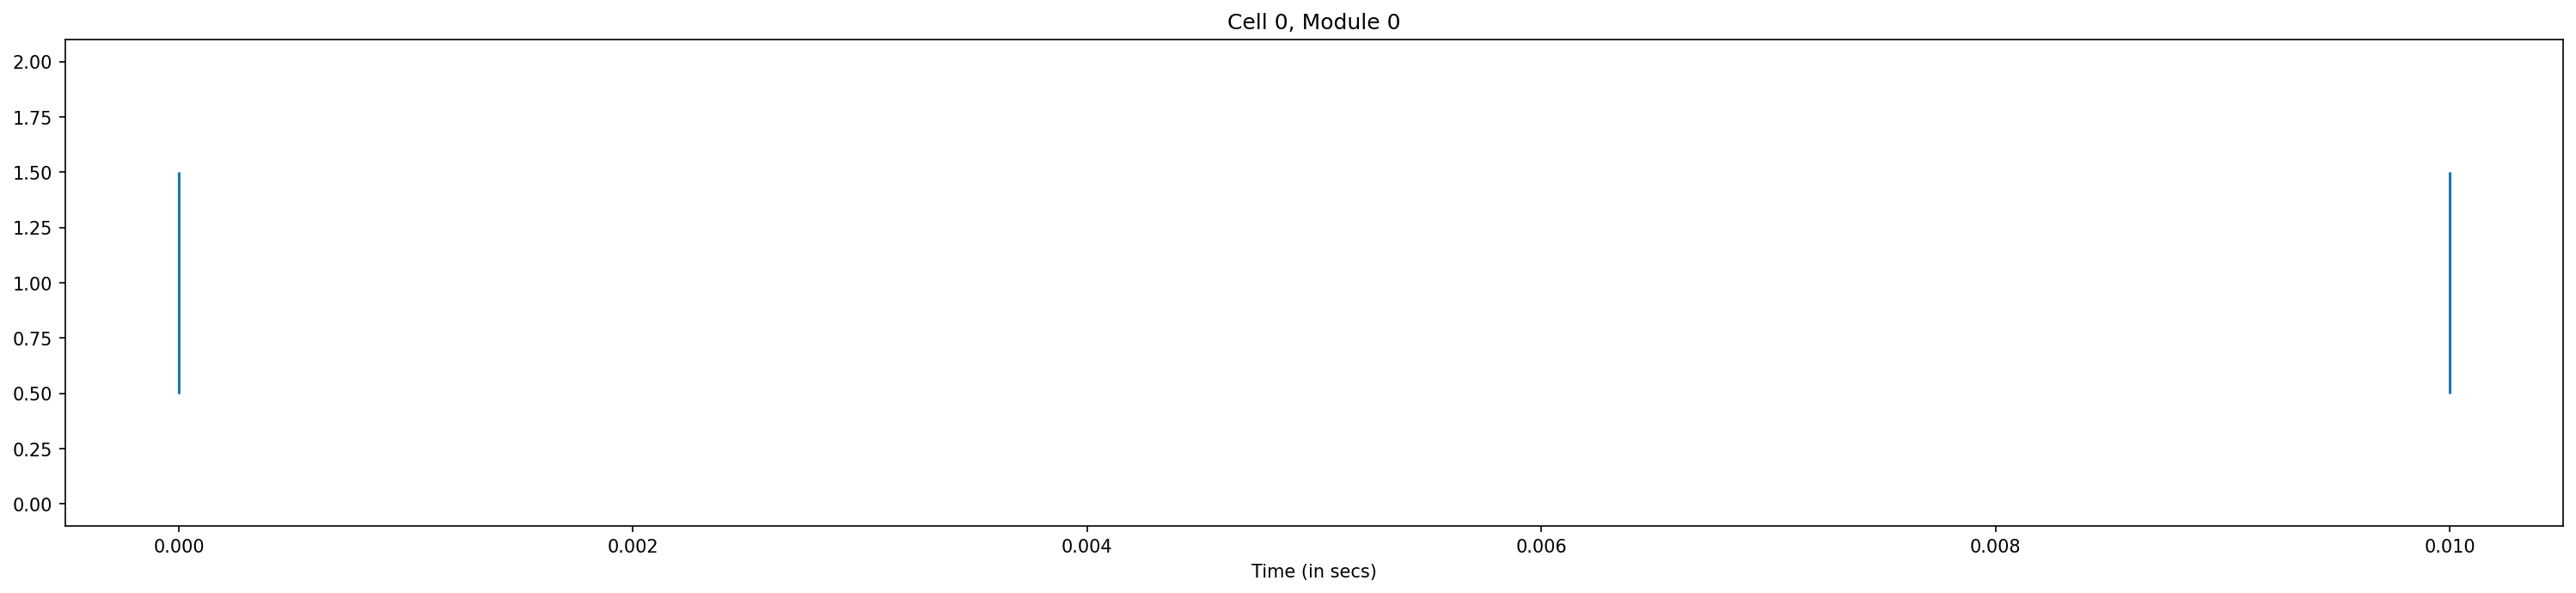

In [ ]:
raster_plot_singlecell(activity[0, :, 0], 'Cell 0, Module 0', args)

In [ ]:
def plot_combined_cell(spike_train, spatial_modulation, theta_modulation, title, args, figsize=[25, 15], dpi=150):
  """
  Create a single plot with 3 subplots: neural tuning curve, theta modulation, spike train raster
  Inputs:

  Returns:

  """

  dt = args['step_size']
  nb_steps = args['nb_steps']

  
  fig, ax = plt.subplots(3, 1, sharex=True, figsize=figsize, dpi=dpi)
  #fig.figsize(figsize)
  #fig.dpi(dpi)

  # plot spatial modulation factor

  time = np.arange(0, nb_steps*dt, dt) # x-coordinates in plot

  ax[0].plot(time, spatial_modulation)
  ax[0].set_title(title)
  ax[0].set_xlabel("Time (in secs)")

  
  # plot theta modulation factor

  ax[1].plot(time, theta_modulation)
  ax[1].set_ylabel("Theta Modulation")

  # plot spike train
  positions = np.arange(0, nb_steps)
  spike_times = dt*positions[spike_train >= 1]
  ax[2].eventplot(spike_times)
  
  fig.show()

  

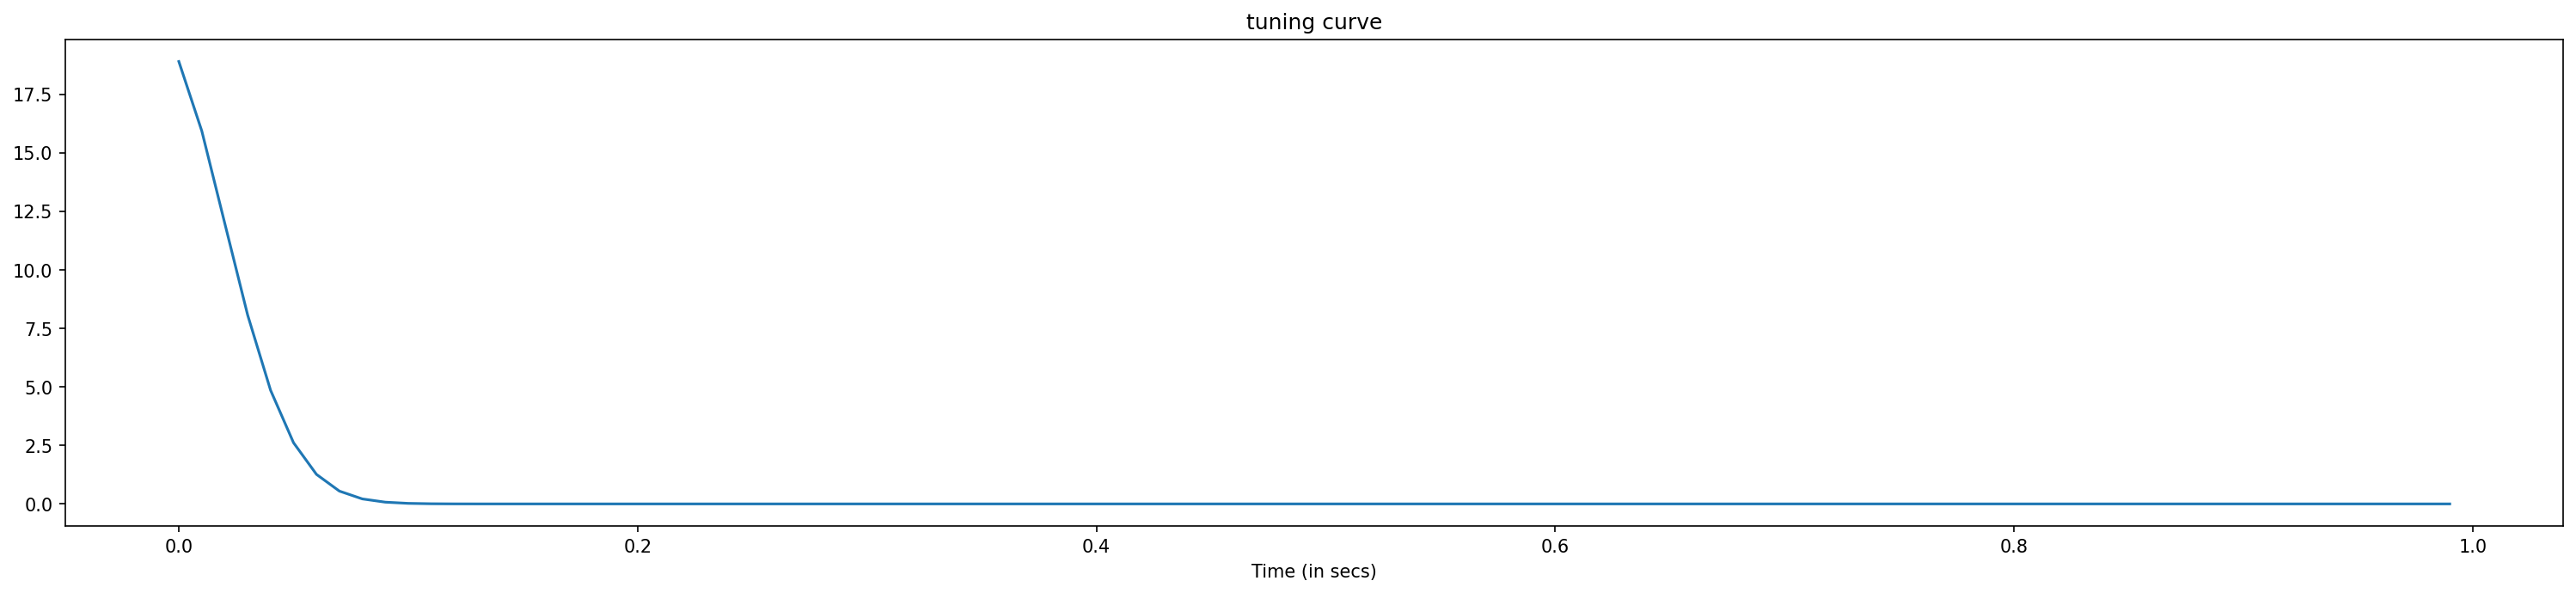

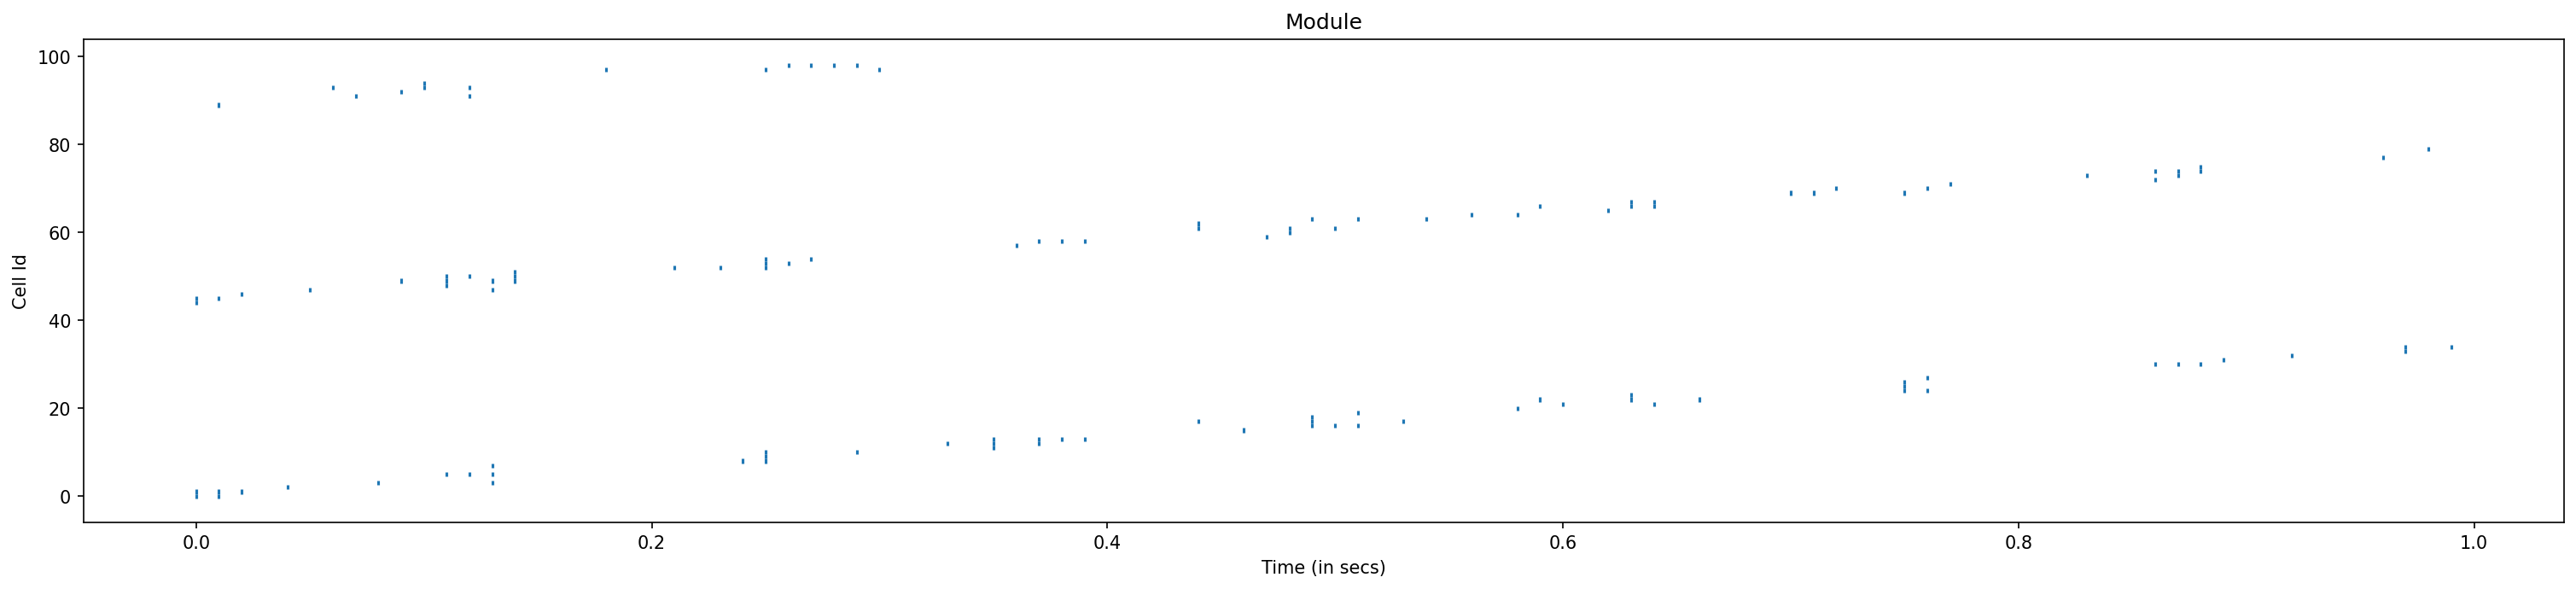

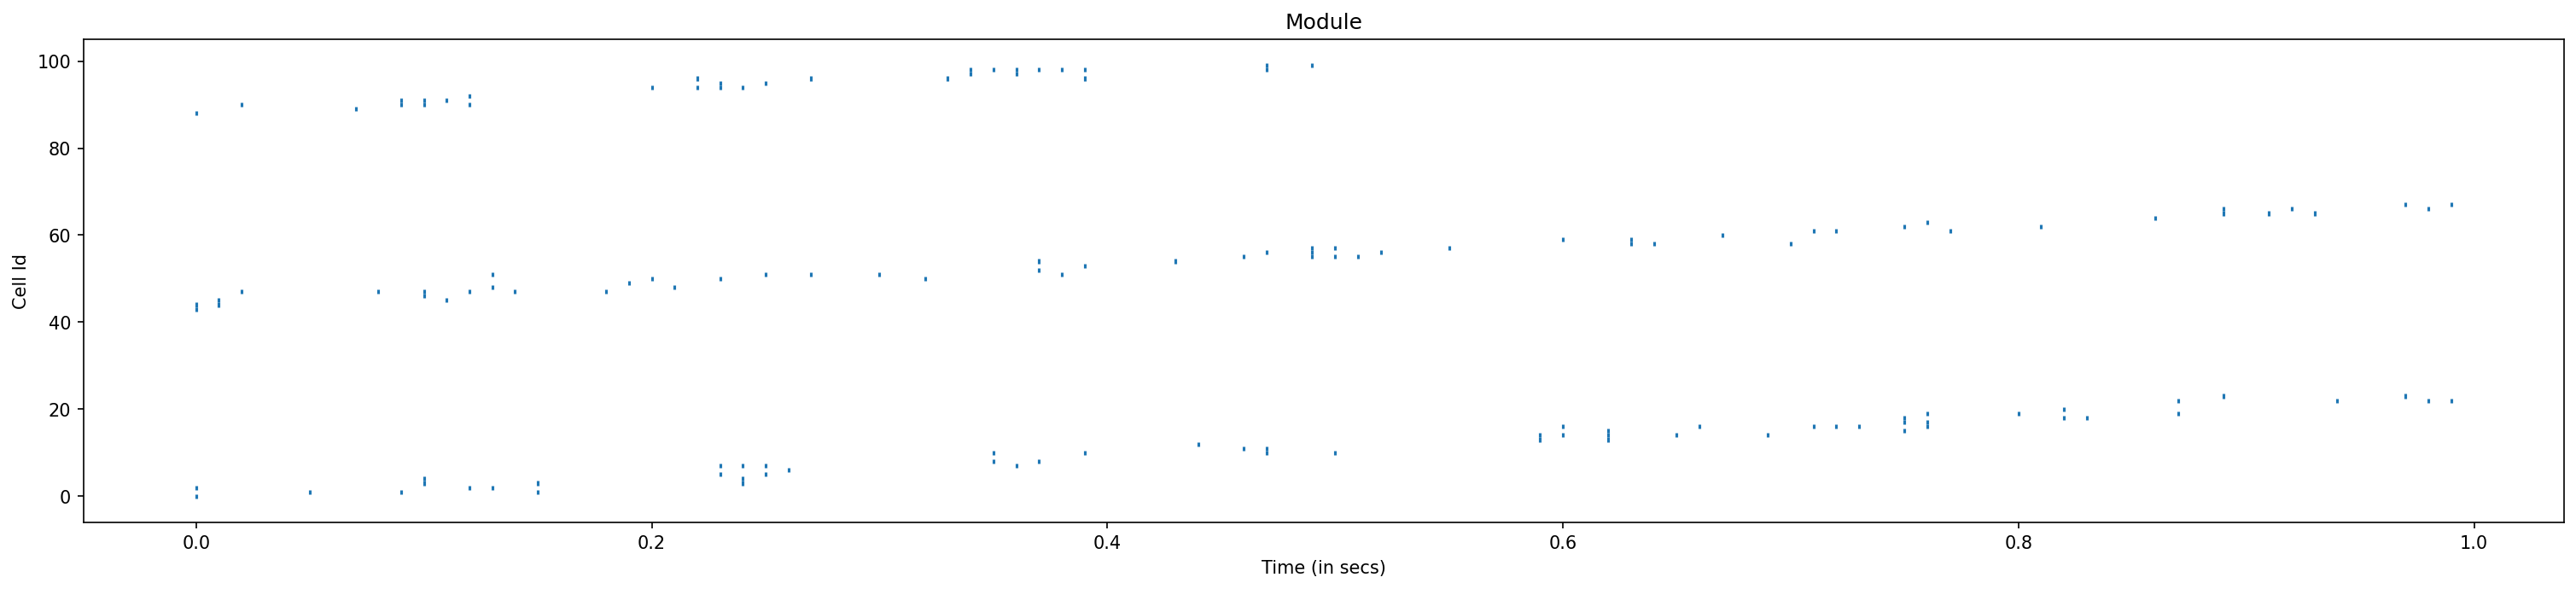

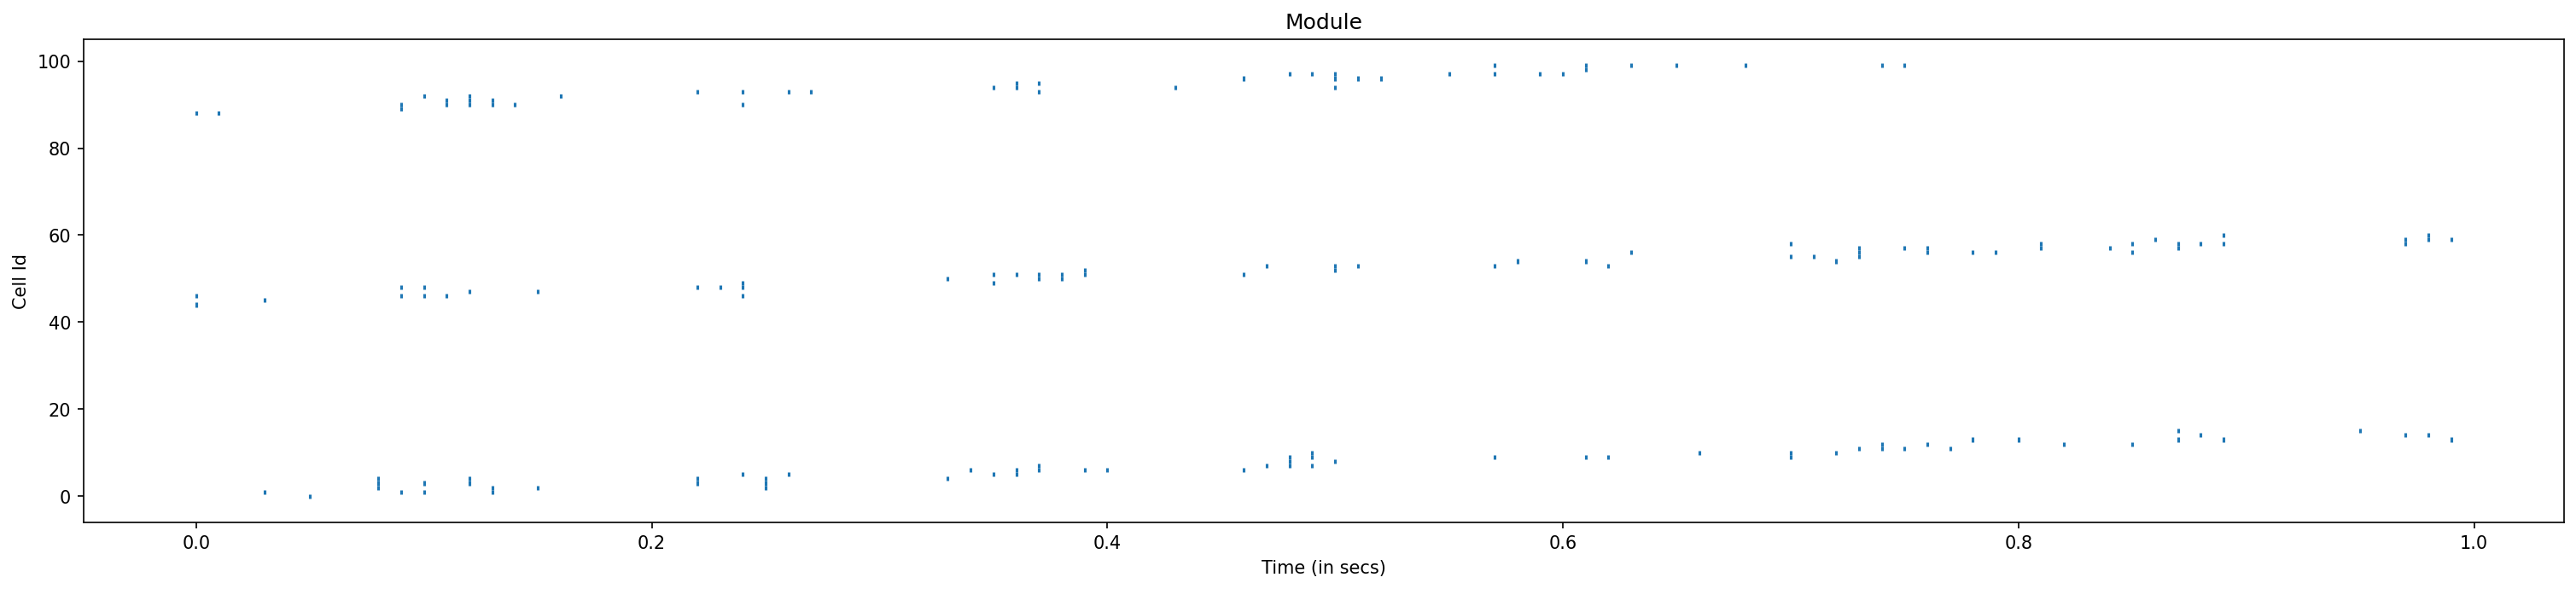

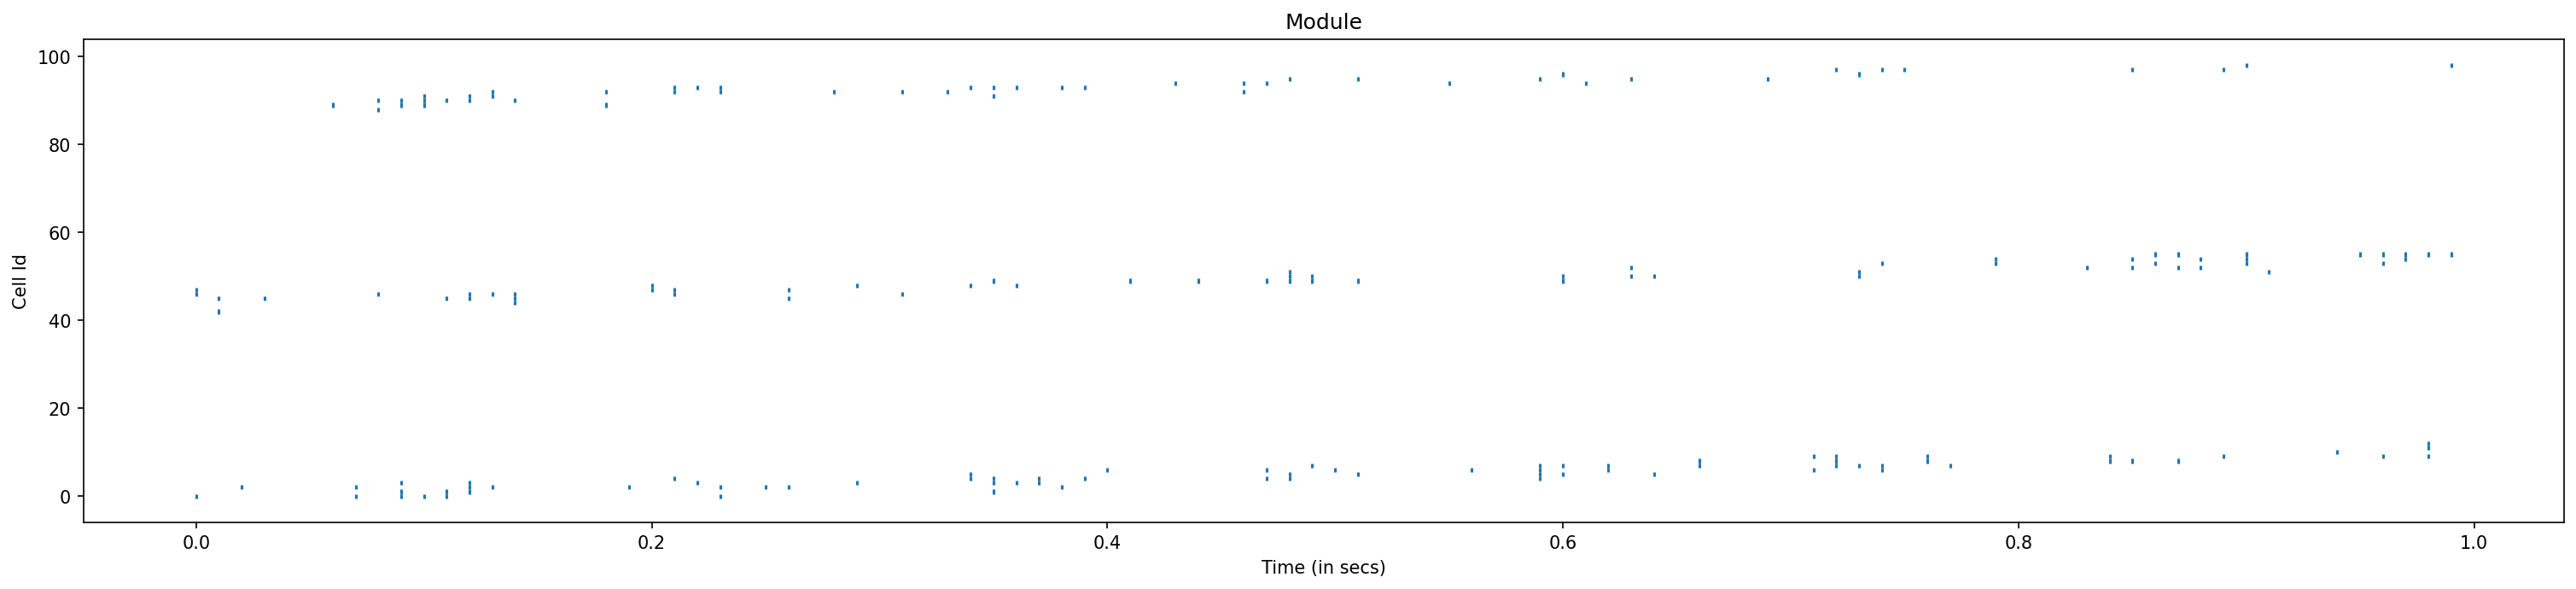

In [ ]:
plot_modulation_factor(spatial_input[0, :, 0], "tuning curve", args)
for i in range(args['nb_modules']):
  raster_plot_module(activity[:, :, i], 'Module', args, figsize=[25,5]) # plot spike trains from the zeroth module

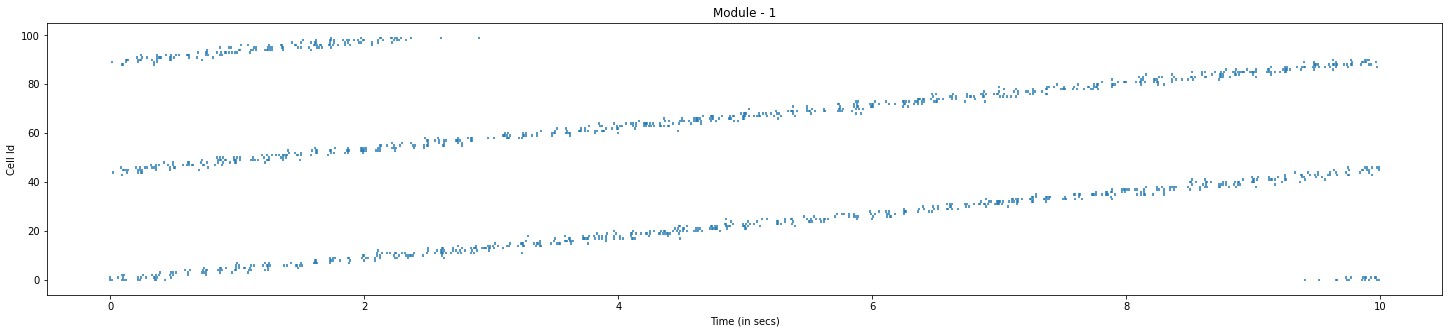

In [ ]:
raster_plot_module(activity[:, :, 1], 'Module - 1', args)

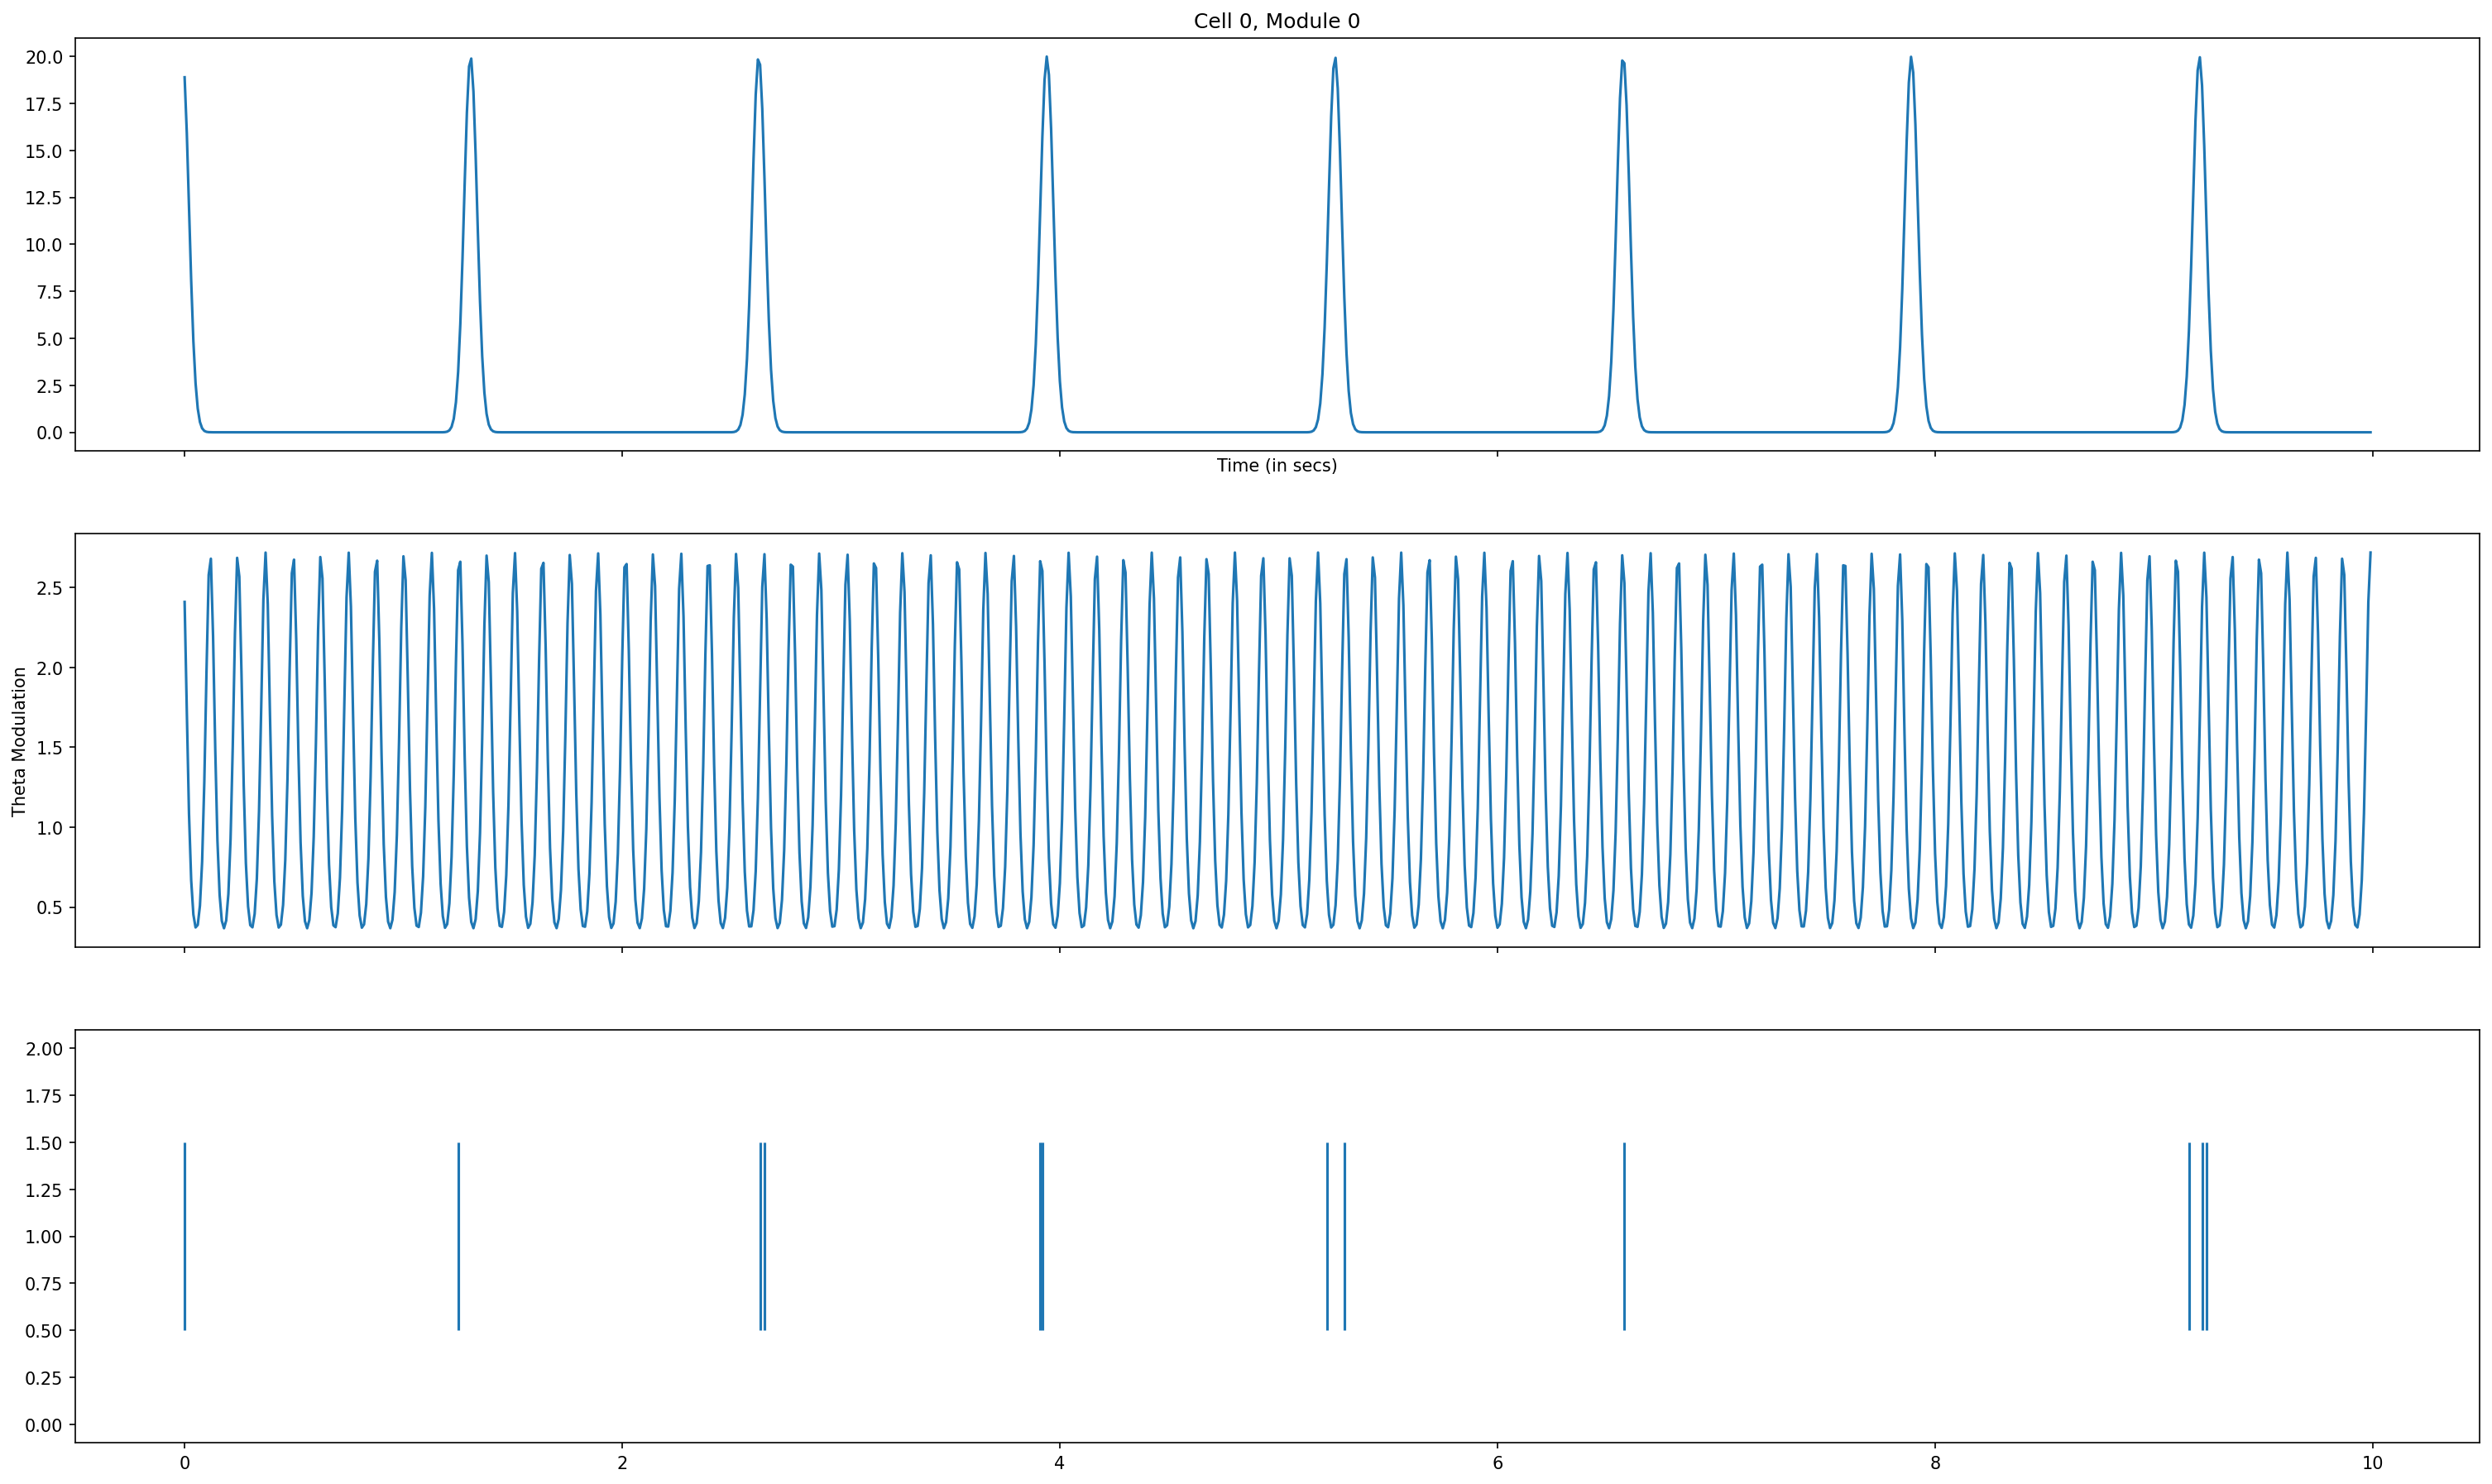

In [ ]:
plot_combined_cell(activity[0, :, 0], spatial_input[0, :, 0], theta_modulation[0, :, 0], "Cell 0, Module 0", args)

In [ ]:
def psth(activity, title, args):
  """

  Input:

  Returns:

  """

  
  100_ms_spike = np.sum(activity[:, i: ]

  plt.plot()
